In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import grader

# ML: Predicting Star Ratings


Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a dataset of venue popularities provided by Yelp.  The dataset contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants. This tutorial will walk you through one way to build a machine-learning algorithm.


## Metric


Your model will be assessed based on the root mean squared error of the number of stars you predict.  There is a reference solution (which should not be too hard to beat).  The reference solution has a score of 1. Keeping this in mind...


## A note on scoring

It **is** possible to score >1 on these questions. This indicates that you've beaten our reference model - we compare our model's score on a test set to your score on a test set. See how high you can go!



## Download and parse the incoming data


In [16]:
#!aws s3 sync s3://dataincubator-course/mldata/ . --exclude '*' --include 'yelp_train_academic_dataset_business.json.gz'

In [3]:
###download already

import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]


In [18]:
#print type(data[1])

In [2]:
print data[1]['attributes']

{u'Take-out': True, u'Price Range': 1, u'Outdoor Seating': False, u'Caters': False, u'Noise Level': u'average', u'Parking': {u'garage': False, u'street': False, u'validated': False, u'lot': True, u'valet': False}, u'Delivery': False, u'Attire': u'casual', u'Has TV': True, u'Good For': {u'dessert': False, u'latenight': False, u'lunch': True, u'dinner': False, u'brunch': False, u'breakfast': False}, u'Takes Reservations': False, u'Ambience': {u'romantic': False, u'intimate': False, u'touristy': False, u'hipster': False, u'divey': False, u'classy': False, u'trendy': False, u'upscale': False, u'casual': False}, u'Waiter Service': True, u'Accepts Credit Cards': True, u'Good for Kids': True, u'Good For Groups': True, u'Alcohol': u'none'}


In [20]:
#print [data[i]['categories'] for i in range(1,100)]

In [4]:
star_ratings = [row['stars'] for row in data]

# Questions


Each of the "model" questions asks you to create a function that models the number of stars venues will receive.  It will be passed a list of dictionaries.  Each of these will have the same format as the JSON objects you've just read in.  Some of the keys (like the stars!) will have been removed.  This function should return a list of numbers of the same length, indicating the predicted star ratings.

This function is passed to the `score()` function, which will receive input from the grader, run your function with that input, report the results back to the grader, and print out the score the grader returned.  Depending on how you constructed your estimator, you may be able to pass the predict method directly to the `score()` function.  If not, you will need to write a small wrapper function to mediate the data types.


## city_avg

The venues belong to different cities.  You can image that the ratings in some cities are probably higher than others.  We wish to build an estimator to make a prediction based on this.  For this problem, create a list of tuples (city name, star rating), one for each city in the dataset.


In [5]:
from collections import defaultdict
star_sum = defaultdict(int)
count = defaultdict(int)

In [6]:
#mycity = [row['city'] for row in data]
for row, stars in zip(data, star_ratings):
#    print (row['city'])
    if row['city'] in star_sum:
        star_sum[row['city']] = star_sum[row['city']] + row['stars']
        count[row['city']]    = count[row['city']] + 1
#        print 'already exist'
#        print star_sum
    else:
        star_sum[row['city']] = row['stars']
        count[row['city']]    = 1
#        print 'new'
#        print star_sum
#print star_sum 
    # increment the running sum in star_sum
    # increment the running count in count

In [24]:
#print len(star_sum)
#print count

In [7]:
avg_stars = dict()
for city in star_sum:
    avg_stars[city] = star_sum[city]/count[city]
#avg_stars[city]. = {city: star_sum[city]/count[city] for city in star_sum}
    # calculate average star rating and store in avg_stars

In [26]:
#print avg_stars.item()

There should be 167 different cities:

In [7]:
assert len(avg_stars) == 167

In [8]:
grader.score('ml__city_avg', lambda: avg_stars.items())

Your score:  1.0


## city_model

Now, let's build a custom estimator that will make a prediction based solely on the city of a venue.  It is tempting to hard-code the answers from the previous section into this model, but we're going to resist and do things properly.

This custom estimator will have a `.fit()` method.  It will receive `data` as its argument `X` and `star_ratings` as `y`, and should repeat the calculation of the previous problem there.  Then the `.predict()` method can look up the average rating for the city of each record it receives.

In [29]:
#from statistics import mode

In [9]:
from sklearn import base

class CityEstimator(base.BaseEstimator, base.RegressorMixin): 
    def __init__(self):
        self.avg_stars = dict()

    def fit(self, X, y):
        for row, stars in zip(X,y):
            if row['city'] in self.avg_stars:
                self.avg_stars[row['city']] = self.avg_stars[row['city']] + stars
                count[row['city']]    = count[row['city']] + 1
            else:
                self.avg_stars[row['city']] = stars
                count[row['city']]    = 1
        for row in self.avg_stars:
            self.avg_stars[row] = self.avg_stars[row]/count[row]
        return self
    
    def predict(self, X):
        if row['city'] in self.avg_stars:
            return [self.avg_stars[row['city']] for r in X]
        else:
            return median([row['stars'] for r in X])       
#            return  sum([row['stars'] for r in X])/len([row['stars'] for r in X])  

In [31]:
#print sum([row['stars'] for row in data])/len([row['stars'] for row in data])

In [11]:
city_est = CityEstimator()
city_est.fit(data, star_ratings)

CityEstimator()

In [33]:
city_est.predict(data[:5])

[3.7963391136801543,
 3.7963391136801543,
 3.7963391136801543,
 3.7963391136801543,
 3.7963391136801543]

In [12]:
grader.score('ml__city_model', city_est.predict)

Your score:  0.984277465908


## lat_long_model

You can imagine that a city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.


In [13]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        trans_list = []
        for i in X:
            trans_list.append([i[j] for j in self.col_names])
        return trans_list

In [37]:
'''
cst = ColumnSelectTransformer(['categories'])
#print data[:1]
print (cst.fit_transform(data[:1]))
print [[data[0]['latitude'], data[0]['longitude']]]
'''

"\ncst = ColumnSelectTransformer(['categories'])\n#print data[:1]\nprint (cst.fit_transform(data[:1]))\nprint [[data[0]['latitude'], data[0]['longitude']]]\n"

In [15]:
from sklearn.neighbors import KNeighborsRegressor

data_transform = cst.fit_transform(data)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)
test_data = data[:5]
test_data_transform = cst.transform(test_data)
knn.predict(test_data_transform)

array([ 4. ,  4.2,  4. ,  3.8,  4.2])

In [16]:
from sklearn.pipeline import Pipeline

lat_lon_est = Pipeline([('column_selector',ColumnSelectTransformer(['latitude', 'longitude'])),
                 ('KNregressor',KNeighborsRegressor(n_neighbors=5))
        # ColumnSelectTransformer
        # KNeighborsRegressor
    ])

In [17]:
lat_lon_est.fit(data, star_ratings)
#lat_lon_est.predict(test_data)

Pipeline(memory=None,
     steps=[('column_selector', ColumnSelectTransformer(col_names=['latitude', 'longitude'])), ('KNregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))])

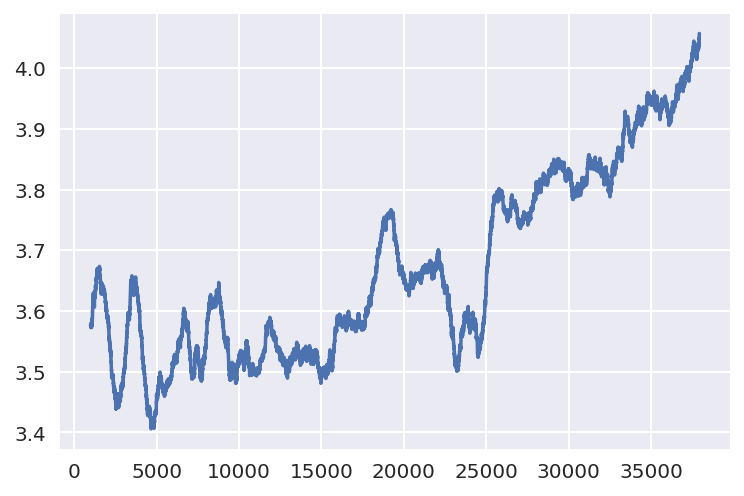

In [18]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean())

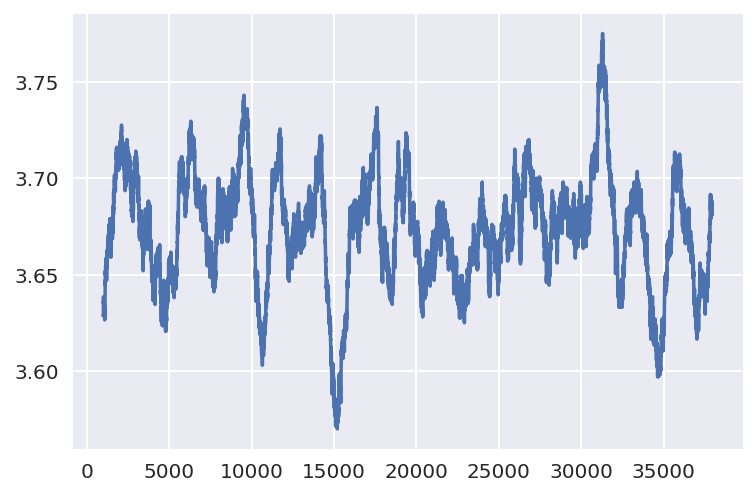

In [19]:
from sklearn.utils import shuffle

shuffled_data = shuffle(data)
shuffled_star_ratings = [row['stars'] for row in shuffled_data]
plt.plot(Series.rolling(Series(shuffled_star_ratings), window=1000).mean())


In [167]:
'''
 the value of k is non-parametric and a general rule of thumb in choosing the value of k 
 is k = sqrt(N)/2, where N stands for the number of samples in your training dataset.
 Another tip that I suggest is to try and keep the value of k odd, so that there is no tie 
 between choosing a class but that points to the fact that training data is highly 
 correlated between classes and using a simple classification algorithm such as k-NN would
 result in poor classification performance.
 '''
ts = (int(len(data)**(0.5)/2))-50
te = (int(len(data)**(0.5)/2))+50
#print cv_score

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
import numpy as np
cst = ColumnSelectTransformer(['latitude', 'longitude'])
shuffled_data_transform = cst.fit_transform(shuffled_data)
neighbors = range(ts,te)
cv_score = []
for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    cv_score.append([k,np.mean(cross_val_score(knn, shuffled_data_transform, shuffled_star_ratings,cv=10))])


The optimal number of neighbors is 55


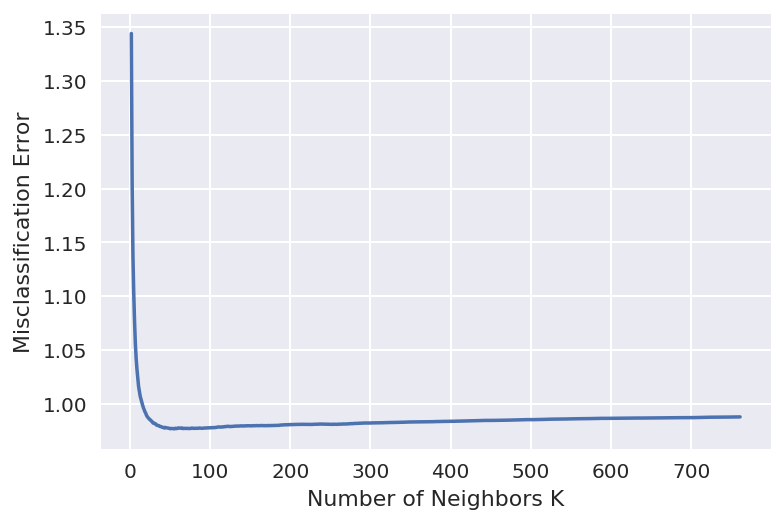

In [162]:
#### FIRST TRIED WITH RANGE (2,1000) AND PLOTTED 
# Misclassification Error
MSE = [1 - x for x in [y[1] for y in cv_score]]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print "The optimal number of neighbors is %d" % optimal_k

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [169]:
from operator import itemgetter
best_k = max(cv_score,key=itemgetter(1))[0]
print best_k

55


In [170]:
assert (best_k == optimal_k)

In [20]:
best_k = 55
lat_lon_est = Pipeline([('column_selector',ColumnSelectTransformer(['latitude', 'longitude'])),
                 ('KNregressor',KNeighborsRegressor(n_neighbors=best_k))])
lat_lon_est.fit(shuffled_data, shuffled_star_ratings)
#pipe.predict(test_data)


Pipeline(memory=None,
     steps=[('column_selector', ColumnSelectTransformer(col_names=['latitude', 'longitude'])), ('KNregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=55, p=2,
          weights='uniform'))])

In [21]:
grader.score('ml__lat_long_model', lat_lon_est.predict)  # Edit to appropriate name

Your score:  1.08582366531


## category_model

While location is important, we could also try seeing how predictive the
venue's category is.  Build an estimator that considers only the categories.

In [22]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        list_dic_cat = []
        for i in X: 
            dic_cat = {}
            for k in i[0]:
                dic_cat[k] = 1
            list_dic_cat.append(dic_cat)
        return list_dic_cat
        # X will come in as a list of lists of lists.  Return a list of
        # dictionaries corresponding to those inner lists.

In [16]:
assert (DictEncoder().fit_transform([[['a']], [['b', 'c']]])
        == [{'a': 1}, {'b': 1, 'c': 1}])

In [23]:
from sklearn.feature_extraction import DictVectorizer
'''
cst           = ColumnSelectTransformer(['categories'])
dv            = DictVectorizer(sparse=False)
a             = DictEncoder().fit_transform(cst.fit_transform(shuffled_data))
dv_categories = dv.fit_transform(a)
#print a[:10]
#print dv_categories.shape
'''

"\ncst           = ColumnSelectTransformer(['categories'])\ndv            = DictVectorizer(sparse=False)\na             = DictEncoder().fit_transform(cst.fit_transform(shuffled_data))\ndv_categories = dv.fit_transform(a)\n#print a[:10]\n#print dv_categories.shape\n"

In [ ]:
'''
Q3_data_transform = cst.fit_transform(new_data)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Q3_data_transform, new_star_ratings)
test_data = new_data[:5]
test_data_transform = cst.transform(test_data)
knn.predict(test_data_transform)

pipe = Pipeline([('column_selector',ColumnSelectTransformer(['categories'])),
                 ('KNregressor',KNeighborsRegressor(n_neighbors=best_k))])
pipe.fit(new_data, new_star_ratings)
pipe.predict(test_data)
'''

In [24]:
#from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
category_est = Pipeline([('column_selector',ColumnSelectTransformer(['categories'])),
                 ('dict_enc',DictEncoder()),
                 ('dict_vec',DictVectorizer(sparse=False)),
                 ('ridge',Ridge(alpha = 6.81))])
category_est.fit(shuffled_data, shuffled_star_ratings)

Pipeline(memory=None,
     steps=[('column_selector', ColumnSelectTransformer(col_names=['categories'])), ('dict_enc', DictEncoder()), ('dict_vec', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('ridge', Ridge(alpha=6.81, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [70]:
cv_score_categories = []
alphat = np.arange(6.7,6.9, 0.01)
for alphai in alphat:
    category_est = Pipeline([('column_selector',ColumnSelectTransformer(['categories'])),
                 ('dict_enc',DictEncoder()),
                 ('dict_vec',DictVectorizer(sparse=False)),
                 ('ridge',Ridge(alpha = alphai))])    
    cv_score_categories.append([alphai,np.mean(cross_val_score(category_est, shuffled_data, shuffled_star_ratings,cv=10))])
#print cv_score_categories

[[6.7000000000000002, 0.17725577932175315], [6.71, 0.17725585037794733], [6.7199999999999998, 0.17725591436444327], [6.7299999999999995, 0.17725597130368131], [6.7399999999999993, 0.17725602121800499], [6.7499999999999991, 0.17725606412966172], [6.7599999999999989, 0.17725610006080331], [6.7699999999999987, 0.17725612903348628], [6.7799999999999985, 0.17725615106967268], [6.7899999999999983, 0.17725616619123061], [6.799999999999998, 0.17725617441993466], [6.8099999999999978, 0.17725617577746638], [6.8199999999999976, 0.1772561702854149], [6.8299999999999974, 0.17725615796527733], [6.8399999999999972, 0.17725613883845961], [6.849999999999997, 0.17725611292627633], [6.8599999999999968, 0.17725608024995215], [6.8699999999999966, 0.17725604083062163], [6.8799999999999963, 0.17725599468932984], [6.8899999999999961, 0.17725594184703311], [6.8999999999999959, 0.17725588232459935]]


In [79]:
'''
print len(cv_score_categories)
print len(np.arange(0.0,10, 0.1))
print alphai
'''
print ([x[1] for x in cv_score_categories])
print max([x[1] for x in cv_score_categories])
print cv_score_categories[11]
#alpha = 1.9
#[0.29000000000000009, 0.17121374507968928]

[0.17725577932175315, 0.17725585037794733, 0.17725591436444327, 0.17725597130368131, 0.17725602121800499, 0.17725606412966172, 0.17725610006080331, 0.17725612903348628, 0.17725615106967268, 0.17725616619123061, 0.17725617441993466, 0.17725617577746638, 0.1772561702854149, 0.17725615796527733, 0.17725613883845961, 0.17725611292627633, 0.17725608024995215, 0.17725604083062163, 0.17725599468932984, 0.17725594184703311, 0.17725588232459935]
0.177256175777
[6.8099999999999978, 0.17725617577746638]


The optimal value for alpha is 6


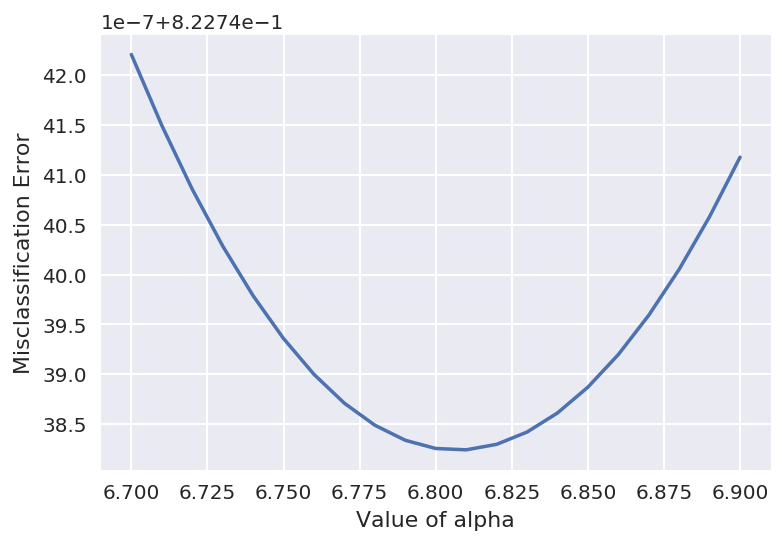

In [72]:
#### FIRST TRIED WITH RANGE (2,1000) AND PLOTTED 
# Misclassification Error
MSE = [1 - x for x in [y[1] for y in cv_score_categories]]

# determining best k
optimal_alpha = alphat[MSE.index(min(MSE))]
print "The optimal value for alpha is %d" % optimal_alpha

# plot misclassification error vs k
plt.plot(alphat, MSE)
plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

The optimal value for alpha is 2


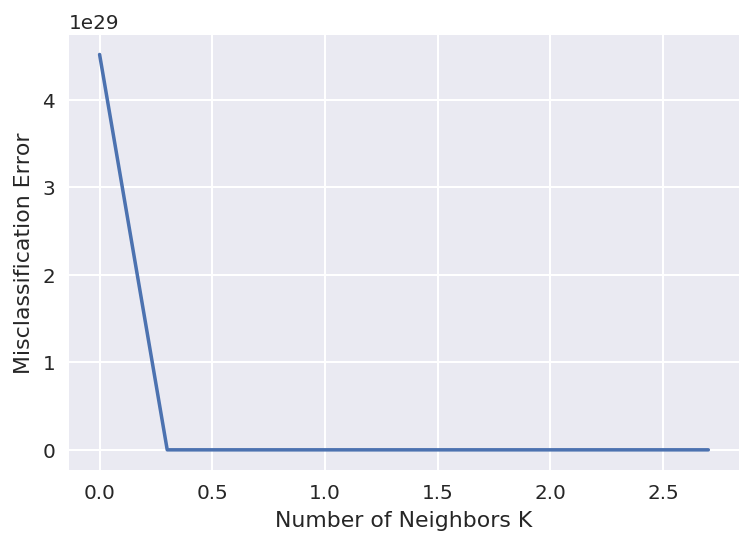

In [48]:
#### FIRST TRIED WITH RANGE (2,1000) AND PLOTTED 
# Misclassification Error
MSE = [1 - x for x in [y[1] for y in cv_score_categories]]

# determining best k
optimal_alpha = float(alphat[MSE.index(min(MSE))])
print "The optimal value for alpha is %d" % optimal_alpha

# plot misclassification error vs k
plt.plot(alphat, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

The optimal value for alpha is 0


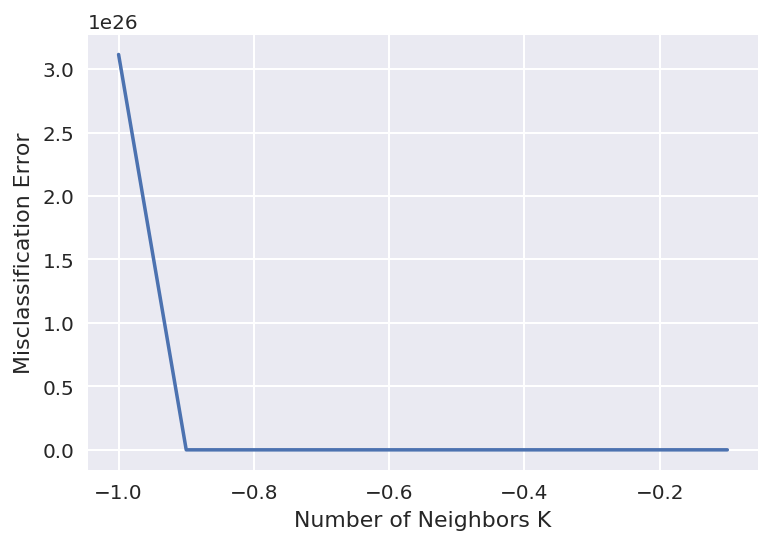

In [50]:
#### FIRST TRIED WITH RANGE (2,1000) AND PLOTTED 
# Misclassification Error
MSE = [1 - x for x in [y[1] for y in cv_score_categories]]

# determining best k
optimal_alpha = float(alphat[MSE.index(min(MSE))])
print "The optimal value for alpha is %d" % optimal_alpha

# plot misclassification error vs k
plt.plot(alphat, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [25]:
grader.score('ml__category_model', category_est.predict)  # Edit to appropriate name

Your score:  0.998675571217


## attribute_model

There is even more information in the attributes for each venue.  Build an estimator based on these.

Venues attributes may be nested:
```
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them with one-hot encoding.  The `DictVectorizer` can do this, but only once we've flattened the dictionary to a single level, like so:
```
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```

Build a custom transformer that flattens the attributes dictionary.  Place this in a pipeline with a `DictVectorizer` and a regressor.


In [26]:
###Flatten a dictionary:
import sys
def flat(the_dict):
#    print type(the_dict)
#    print the_dict
    result={}
    for the_key in the_dict:
        da=the_dict[the_key]
        if isinstance(da,str):
            result[the_key+'_'+da]=1
        elif isinstance(da,unicode):
            result[the_key+'_'+da]=1
        elif isinstance(da,int):
            result[the_key+'_'+str(da)]=1
        elif isinstance(da,bool):
            result[the_key]=int(da)
        elif isinstance(da,dict):
            
            resultl=flat(da)
            for the_key_l in resultl:
                result[the_key+'_'+the_key_l]=resultl[the_key_l]
        else:
            print 'Error', the_key, da
            sys.exit()
    return result

class Att_Flat(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [flat(row['attributes']) for row in X]

In [163]:
DictVectorizer(sparse=False).fit_transform(Att_Flat().fit_transform(data)).shape

(37938, 166)

In [167]:
(Att_Flat().fit_transform([data[1]]))

average
casual
none


[{u'Accepts Credit Cards_True': 1,
  u'Alcohol_none': 1,
  u'Ambience_casual_False': 1,
  u'Ambience_classy_False': 1,
  u'Ambience_divey_False': 1,
  u'Ambience_hipster_False': 1,
  u'Ambience_intimate_False': 1,
  u'Ambience_romantic_False': 1,
  u'Ambience_touristy_False': 1,
  u'Ambience_trendy_False': 1,
  u'Ambience_upscale_False': 1,
  u'Attire_casual': 1,
  u'Caters_False': 1,
  u'Delivery_False': 1,
  u'Good For Groups_True': 1,
  u'Good For_breakfast_False': 1,
  u'Good For_brunch_False': 1,
  u'Good For_dessert_False': 1,
  u'Good For_dinner_False': 1,
  u'Good For_latenight_False': 1,
  u'Good For_lunch_True': 1,
  u'Good for Kids_True': 1,
  u'Has TV_True': 1,
  u'Noise Level_average': 1,
  u'Outdoor Seating_False': 1,
  u'Parking_garage_False': 1,
  u'Parking_lot_True': 1,
  u'Parking_street_False': 1,
  u'Parking_valet_False': 1,
  u'Parking_validated_False': 1,
  u'Price Range_1': 1,
  u'Take-out_True': 1,
  u'Takes Reservations_False': 1,
  u'Waiter Service_True': 1}]

In [27]:
from sklearn.linear_model import Ridge
att_est = Pipeline([('make_flat',Att_Flat()),
                 ('dict_vec',DictVectorizer(sparse=False)),
                 ('ridge',Ridge(alpha = 6.81))])
att_est.fit(shuffled_data, shuffled_star_ratings)

Pipeline(memory=None,
     steps=[('make_flat', Att_Flat()), ('dict_vec', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('ridge', Ridge(alpha=6.81, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [28]:
#ensemble_pipe.fit(shuffled_data, shuffled_star_ratings)
grader.score('ml__attribute_model', att_est.predict)  # Edit to appropriate name

Your score:  0.920358970347


## full_model

So far we have only built models based on individual features.  Now build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to an estimator, you have to turn them into transformers.  (A pipeline can contain at most a single estimator.)  Build a custom `ModelTransformer` class that takes an estimator as an argument.  When `fit()` is called, the estimator should be fit.  When `transform()` is called, the estimator's `predict()` method should be called, and its results returned.

Note that the output of the `transform()` method should be a 2-D array with a single column, in order for it to work well with the Scikit Learn pipeline.  If you're using Numpy arrays, you can use `.reshape(-1, 1)` to create a column vector.  If you are just using Python lists, you will want a list of lists of single elements.

In [29]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        self.base_estimator = estimator
        # What needs to be done here?
    
    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        return self
        # Fit the stored estimator.
        # Question: what should be returned?
    
    def transform(self, X):
        est = self.base_estimator
        return (np.array(est.predict(X))).reshape(-1,1)
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.

This should work as follows:

In [30]:
import numpy as np
city_trans = EstimatorTransformer(city_est)
city_trans.fit(data, star_ratings)
assert ([r[0] for r in city_trans.transform(data[:5])]
        == city_est.predict(data[:5]))

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[FeatureUnion](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [31]:
from sklearn.pipeline import FeatureUnion


union = FeatureUnion([('city',EstimatorTransformer(city_est)),('lat-long',EstimatorTransformer(lat_lon_est)),('category',EstimatorTransformer(category_est)),
                      ('attribute',EstimatorTransformer(att_est))])

In [32]:
union.fit(shuffled_data, shuffled_star_ratings)
trans_data = union.transform(data[:10])
assert trans_data.shape == (10, 4)

In [33]:
alpha =1
full_est=Pipeline([("features", union),("ridge", Ridge(alpha = alpha))])
full_est.fit(shuffled_data, shuffled_star_ratings)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('city', EstimatorTransformer(estimator=None)), ('lat-long', EstimatorTransformer(estimator=None)), ('category', EstimatorTransformer(estimator=None)), ('attribute', EstimatorTransformer(estimator=None))],
       transformer_weights=None)), ('ridge', Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [34]:
grader.score('ml__full_model', full_est.predict)  # Edit to appropriate name

Your score:  0.973410835323


*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*